# 0. Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import category_encoders as ce
import xgboost as xgb

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91927 entries, 0 to 91926
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                91927 non-null  int64  
 1   model_id                  91927 non-null  int64  
 2   year                      91927 non-null  int64  
 3   family_label              91927 non-null  object 
 4   sub_department_label      91927 non-null  object 
 5   department_label          91927 non-null  object 
 6   univers_label             91927 non-null  object 
 7   product_nature_label      91927 non-null  object 
 8   brand_label               91927 non-null  object 
 9   product_technicity_level  62801 non-null  object 
 10  color_name                61655 non-null  object 
 11  average_price             91927 non-null  float64
 12  nb_store_max              91927 non-null  int64  
 13  nb_store_min              91927 non-null  int64  
 14  sales_

# 1.1. Numerical columns

In [6]:
num_cols = ['year', 'average_price', 'nb_store_max', 'nb_store_min']

In [7]:
train[num_cols].describe()

,year,average_price,nb_store_max,nb_store_min
count,91927.000000,91927.000000,91927.000000,91927.000000
mean,2020.581004,26.836007,361.908014,274.369772
std,1.115302,119.219437,315.572193,284.430693
min,2019.000000,0.000000,1.000000,1.000000
25%,2020.000000,4.665000,81.000000,34.000000
50%,2021.000000,9.760000,261.000000,165.000000
75%,2022.000000,21.230000,615.000000,438.000000
max,2022.000000,14166.770000,1193.000000,1178.000000


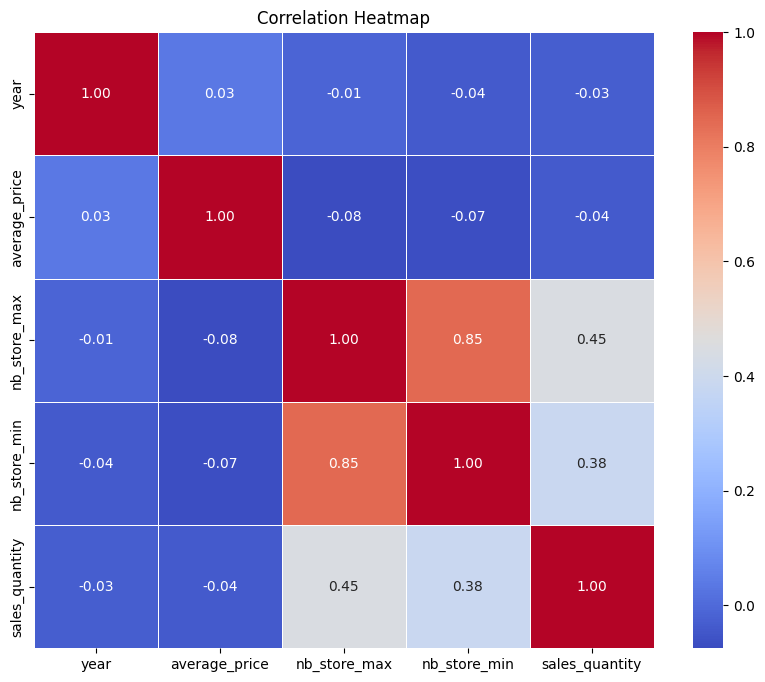

In [8]:
correlation_matrix = train[num_cols + ['sales_quantity']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
train.sales_quantity.describe()

count     91927.000000
mean       7639.606220
std       22993.348306
min           0.000000
25%         243.000000
50%        1416.000000
75%        6199.000000
max      976322.000000
Name: sales_quantity, dtype: float64

<Axes: xlabel='sales_quantity', ylabel='Count'>

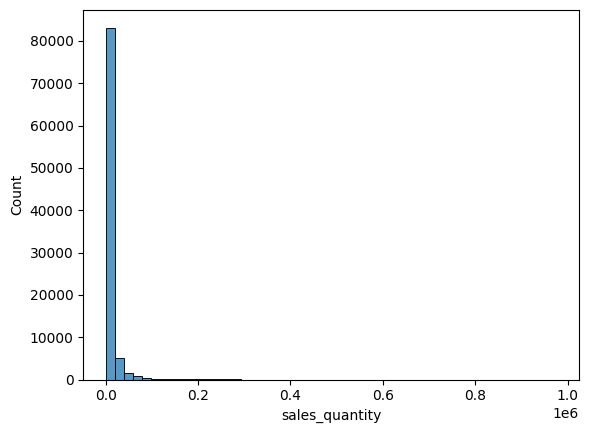

In [10]:
sns.histplot(x=train.sales_quantity, bins=50)

In [11]:
train['log_sales_quantity'] = np.log1p(train.sales_quantity)

In [12]:
print(train.sales_quantity.skew())
print(train.log_sales_quantity.skew())

12.98210160561321
-0.5863810714781638


<Axes: xlabel='log_sales_quantity', ylabel='Count'>

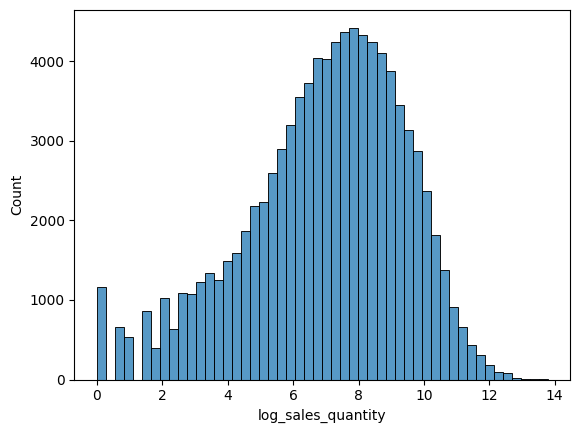

In [13]:
sns.histplot(x=train.log_sales_quantity, bins=50)

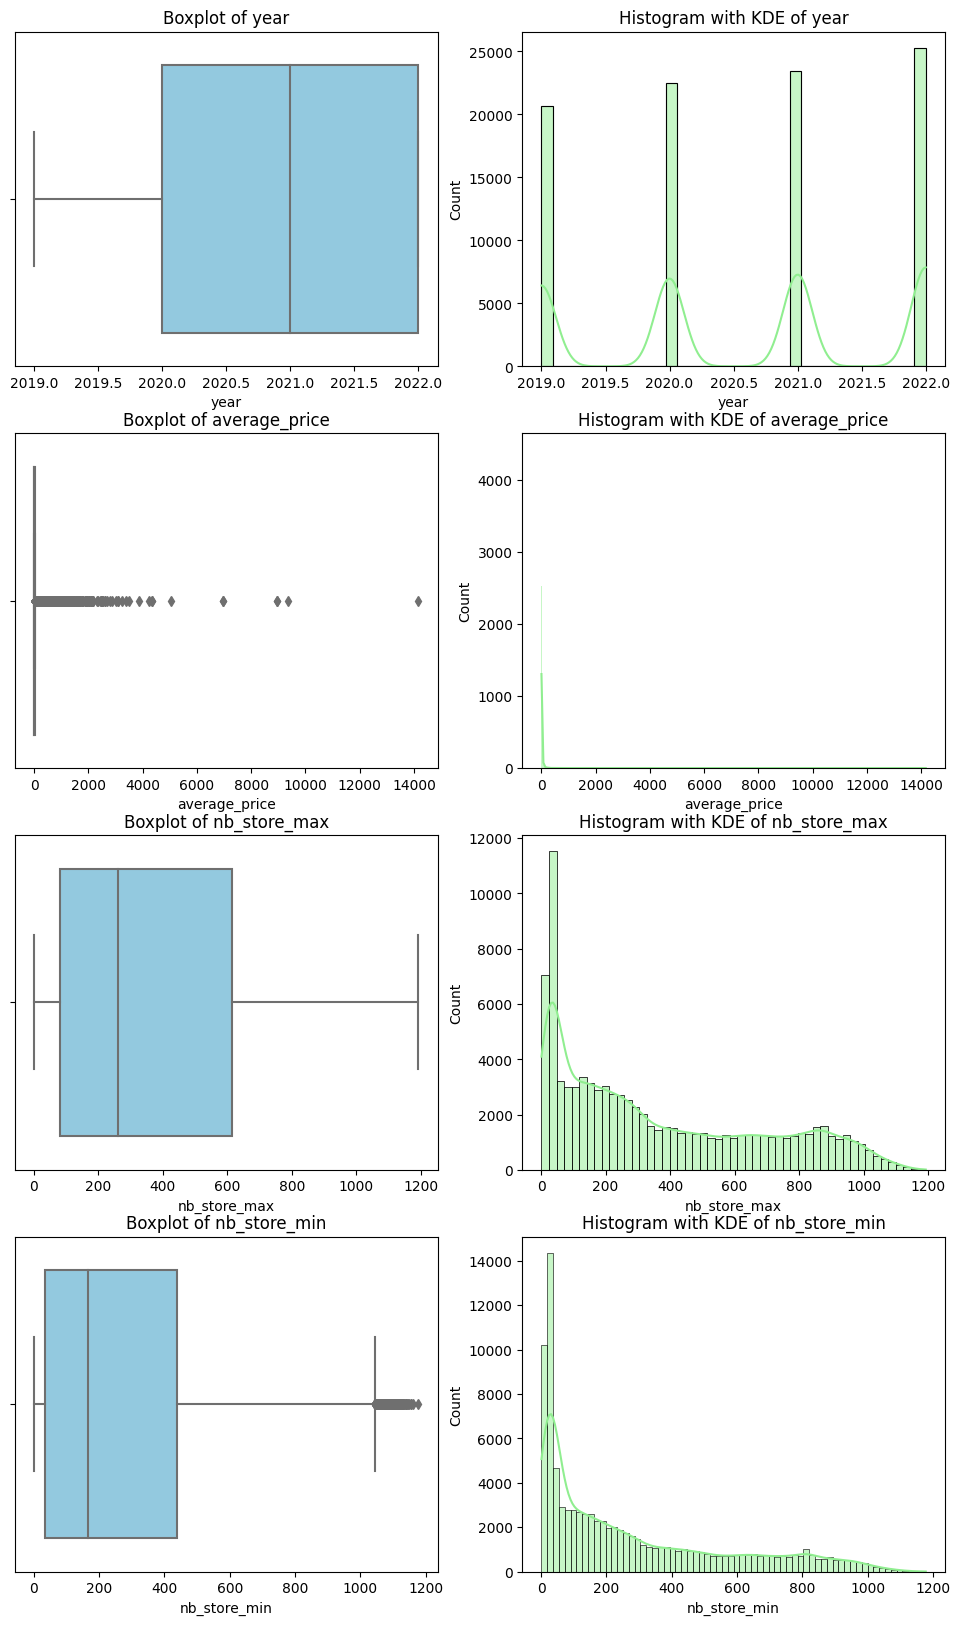

In [14]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x=train[col], ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Boxplot of {col}')
    
    sns.histplot(train[col], kde=True, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Histogram with KDE of {col}')

In [15]:
for col in num_cols:
    correlation = train[col].corr(train['log_sales_quantity'])
    correlation_log = np.log1p(train[col]).corr(train['log_sales_quantity'])
    print(f"Correlation between {col} and 'sales_quantity': {correlation}")
    print(f"Correlation between log_{col} and 'sales_quantity': {correlation_log}")

Correlation between year and 'sales_quantity': -0.08885618589542231
Correlation between log_year and 'sales_quantity': -0.08885357943487258
Correlation between average_price and 'sales_quantity': -0.09370066646140021
Correlation between log_average_price and 'sales_quantity': -0.07357469592254216
Correlation between nb_store_max and 'sales_quantity': 0.7768231985747452
Correlation between log_nb_store_max and 'sales_quantity': 0.8361703201735823
Correlation between nb_store_min and 'sales_quantity': 0.6463183555557883
Correlation between log_nb_store_min and 'sales_quantity': 0.7089032961494623


## 1.2. Categorical columns

In [16]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

In [17]:
train[cat_cols].describe()

,family_label,sub_department_label,department_label,univers_label,product_nature_label,brand_label,product_technicity_level,color_name
count,91927,91927,91927,91927,91927,91927,62801,61655
unique,1337,278,69,20,1755,704,4,364
top,PERFORMANCE & E,SWIMMING,FISHING,FISHING UNIVERS,SPORT SHOES,CAPERLAN,ALL_LEVELS,black
freq,695,3509,11137,11137,4108,7710,22073,9778


In [18]:
train.select_dtypes(include=['object']).isnull().sum()

family_label                    0
sub_department_label            0
department_label                0
univers_label                   0
product_nature_label            0
brand_label                     0
product_technicity_level    29126
color_name                  30272
dtype: int64

In [19]:
n_cols = 2
n_rows = (len(cat_cols) // n_cols) + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 25))

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].set_xticklabels([])
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

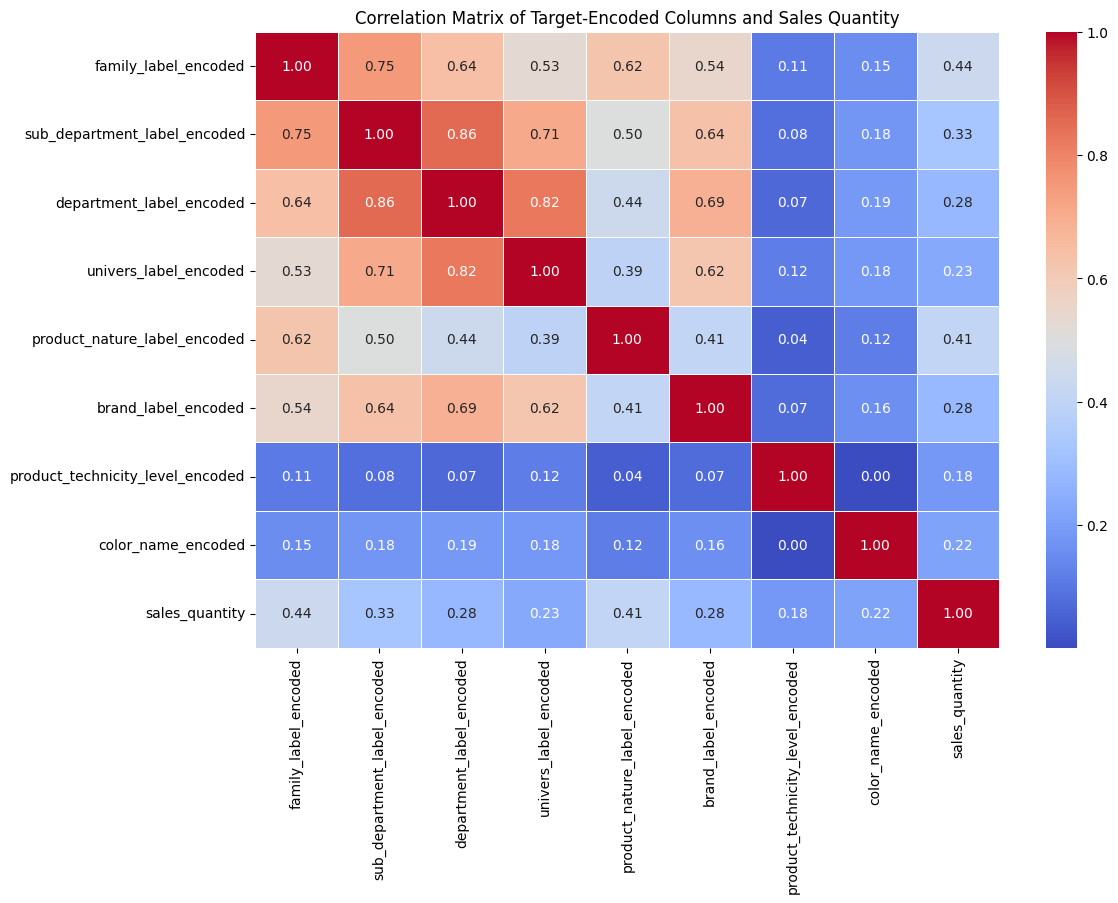

In [20]:
encoded_cols = {}

for col in cat_cols:
    target_mean = train.groupby(col)['sales_quantity'].mean()
    encoded_cols[f'{col}_encoded'] = train[col].map(target_mean)

encoded_df = pd.DataFrame(encoded_cols)
encoded_df['sales_quantity'] = train['sales_quantity']

corr_matrix = encoded_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of Target-Encoded Columns and Sales Quantity')
plt.show()

# 2. Feature engineering

## 2.1. Feature creation

In [21]:
current_year = datetime.now().year
train['age'] = current_year - train['year']
test['age'] = current_year - test['year']

## 2.2. Outliers

In [22]:
train = train[train['average_price'] <= 3000]

## 2.3. Skewness correction

In [23]:
train['log_nb_store_max'] = np.log1p(train.nb_store_max)
train['log_nb_store_min'] = np.log1p(train.nb_store_min)

test['log_nb_store_max'] = np.log1p(test.nb_store_max)
test['log_nb_store_min'] = np.log1p(test.nb_store_min)

## 2.4. NULL values

In [24]:
train['color_name'] = train['color_name'].replace(['-', '--'], 'unknown').fillna('unknown')
test['color_name'] = test['color_name'].replace(['-', '--'], 'unknown').fillna('unknown')

In [25]:
train['product_technicity_level'] = train['product_technicity_level'].fillna('ALL_LEVELS')
test['product_technicity_level'] = test['product_technicity_level'].fillna('ALL_LEVELS')

## 2.3. Encoding categorical columns

In [26]:
train['product_technicity_level'] = train['product_technicity_level'].replace({'100': 1, '500': 2, '900': 3, 'ALL_LEVELS': 0})
test['product_technicity_level'] = test['product_technicity_level'].replace({'100': 1, '500': 2, '900': 3, 'ALL_LEVELS': 0})

## 2.4. Feature selection

In [27]:
train.columns

Index(['Unnamed: 0', 'model_id', 'year', 'family_label',
       'sub_department_label', 'department_label', 'univers_label',
       'product_nature_label', 'brand_label', 'product_technicity_level',
       'color_name', 'average_price', 'nb_store_max', 'nb_store_min',
       'sales_quantity', 'log_sales_quantity', 'age', 'log_nb_store_max',
       'log_nb_store_min'],
      dtype='object')

In [28]:
predictive_cols = ['family_label', 'sub_department_label', 'department_label', 'univers_label','product_nature_label', 'brand_label', 'average_price', 'age', 'log_nb_store_max','log_nb_store_min', 'product_technicity_level', 'color_name']

# 3. Model training

In [46]:
print(len(train[train['year']==2019]))
print(len(train[train['year']==2020]))
print(len(train[train['year']==2021]))
print(len(train[train['year']==2022]))

print(f"\n2022 data represent {len(train[train['year']==2022])*100/len(train[train['year']<2022])}% of total data")

20676
22469
23465
25301

2022 data represent 37.983786218285545% of total data


Since 38% of the data is from 2022, we'll use it for validation. This ensures we don’t use future data to predict past sales.

In [48]:
train_df = train[train['year']<=2021]
val_df = train[train['year']==2022]

In [49]:
pipeline = Pipeline([
    ('target_encoder', ce.TargetEncoder(cols=['family_label', 'sub_department_label', 'department_label', 'univers_label', 'product_nature_label', 'brand_label', 'color_name'])),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5000, learning_rate=0.1, random_state=42))
    ])

In [63]:
X = train[predictive_cols]
y = train['log_sales_quantity']

X_train = train_df[predictive_cols]
y_train = train_df['log_sales_quantity']

X_val = val_df[predictive_cols]
y_val = val_df['log_sales_quantity']

In [52]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
np.sqrt(mse)

11495.504451271314

Text(0, 0.5, 'Prediction')

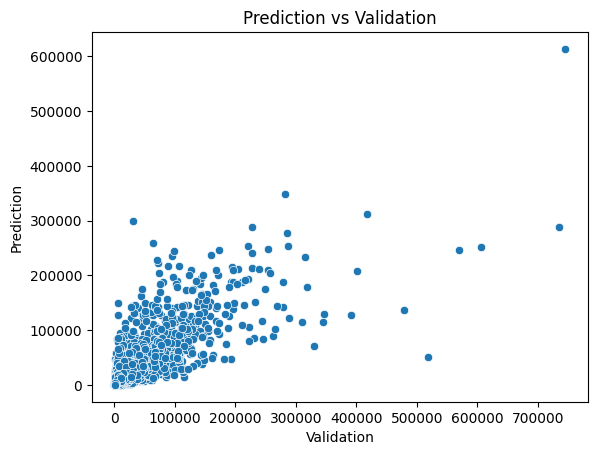

In [53]:
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred))
plt.title('Prediction vs Validation')
plt.xlabel('Validation')
plt.ylabel('Prediction')

In [64]:
pipeline.fit(X, y)
y_sub = pipeline.predict(test[predictive_cols])
y_sub = np.expm1(y_sub)

In [65]:
submission = pd.DataFrame({'ID': test.model_id, 'TARGET': y_sub})

In [66]:
submission.to_csv("submission.csv", index=False)